# Outline

- Create Methods to load & visualize handwritten digits
- Create the Neural Network
- Create the Training & Validation Process
- Create test process

## Create Methods to load & visualize Handwritten digits

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
torch.manual_seed(0)

###### Create the data loader that will load the images in from the directory num_training_class as a pytorch tensor

Transforms documentation
https://pytorch.org/docs/stable/torchvision/transforms.html

torchvision datasets documentation: https://pytorch.org/docs/stable/torchvision/datasets.html

In [3]:
img_path = "./Train"
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
img_dataset = datasets.ImageFolder(img_path,transform)
train_set, val_set = torch.utils.data.random_split(img_dataset, [50000, 10000])
train_data_loader = DataLoader(dataset =train_set,batch_size=16,shuffle=True,num_workers=1)
val_data_loader = DataLoader(dataset =val_set,batch_size=64,shuffle=True,num_workers=1)

###### Create a method to visualize the images that are collected from the data loader

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)),interpolation='nearest')

###### To iterate thru the images we can place the python native iter class over our dataloader and use the next method to load images and their associated labels

In [5]:
data_iter = iter(val_data_loader)
imgs, labels = data_iter.next()

###### Use the show method we created earlier to display all the images in the image batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


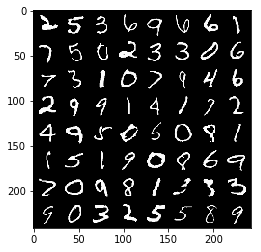

In [6]:
show(make_grid(imgs))

In [7]:
labels

tensor([2, 5, 3, 6, 9, 6, 6, 1, 7, 5, 0, 2, 3, 3, 0, 6, 7, 3, 1, 0, 7, 9, 4, 6,
        2, 9, 9, 1, 4, 1, 7, 2, 4, 9, 5, 0, 5, 0, 8, 1, 1, 5, 1, 9, 0, 8, 6, 9,
        7, 0, 9, 8, 1, 3, 3, 3, 9, 0, 3, 2, 5, 5, 8, 9])

## Create Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

#### We will create a shallow network that has 784 input nodes, a hidden layer with 1000 nodes, and an output layer with 10 nodes representing the 10 possible digits

In [9]:
class Shallow_Network(nn.Module):
    def __init__(self):
        super(Shallow_Network,self).__init__()
        self.fc1 = nn.Linear(28*28,1000)
        self.out = nn.Linear(1000,10)
    def forward(self,input):
        x = F.sigmoid(self.fc1(input))
        return (F.log_softmax(self.out(x),dim=1))

In [ ]:
class Medium_Network(nn.Module):
    def __init__(self):
        super(Medium_Network,self).__init__()
        self.fc1 = nn.Linear(28*28,1000)
        self.fc2 = nn.Linear(1000,2000)
        self.fc3 = nn.Linear(2000,1000)
        self.out = nn.Linear(1000,10)
    def forward(self,input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return (F.log_softmax(self.out(x),dim=1))

In [10]:
net = Shallow_Network()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Load Network onto the GPU

In [11]:
net.to(device)

Shallow_Network(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (out): Linear(in_features=1000, out_features=10, bias=True)
)

## Create Training Process

#### Create your optimizer

In [12]:
import torch.optim as optim

optim documentation https://pytorch.org/docs/stable/optim.html

In [13]:
#Create an stochastic gradient descent optimizer
adam = optim.Adam(net.parameters(), lr=0.001)

#### Create the loss function

In [14]:
loss_func = nn.NLLLoss()
loss_func.to(device)

NLLLoss()

In [15]:
cnt = 0
average_losses = []
average_val_losses = []
acc = []
for epoch in range(20):
    data_iter = iter(train_data_loader)
    cur_loss = []
    while True:
        try:
            net.train()
            #zero the gradient
            adam.zero_grad()
            #load the images and labels
            imgs, labels = data_iter.next()
            #Get output of network
            probs = net(torch.flatten(imgs.to(device), start_dim=1))
            #compute loss
            loss = loss_func(probs,labels.to(device))
            #compute the backward gradient and move network in that direction
            loss.backward()
            adam.step()
            #gather loss
            cur_loss.append(loss.detach().cpu().numpy())
        except:
            break
    print("epoch ",epoch)
    print("training loss: ", np.mean(cur_loss))
    average_losses.append(np.mean(cur_loss))
    
    data_iter = iter(val_data_loader)
    cur_val_loss = []
    cur_acc = []
    while True:
        try:
            net.eval()
            imgs, labels = data_iter.next()
            probs = net(torch.flatten(imgs.to(device), start_dim=1))
            loss = loss_func(probs,labels.to(device))
            cur_val_loss.append(loss.detach().cpu().numpy())
            values, indices = torch.max(probs, 1)
            accuracy = ((indices.to(device) - labels.to(device)) == 0).sum()
            accuracy = accuracy.detach().cpu().numpy() / len(indices)
            #print(accuracy)
            cur_acc.append(accuracy)
        except:
            break
    print("validation loss: ",np.mean(cur_val_loss))
    average_losses.append(np.mean(cur_val_loss))
    print("accuracy: ",np.mean(cur_acc))
    average_losses.append(np.mean(cur_val_loss))
    acc.append(np.mean(cur_acc))

/home/ahonts/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch  0
training loss:  0.31502193
validation loss:  0.19084398
accuracy:  0.9411823248407644
epoch  1
training loss:  0.1503595
validation loss:  0.16218747
accuracy:  0.9510350318471338
epoch  2
training loss:  0.1177014
validation loss:  0.12473176
accuracy:  0.9626791401273885
epoch  3
training loss:  0.09928095
validation loss:  0.10342711
accuracy:  0.96984474522293
epoch  4
training loss:  0.09696482
validation loss:  0.11146723
accuracy:  0.9662619426751592
epoch  5
training loss:  0.089025505
validation loss:  0.113221355
accuracy:  0.9678542993630573
epoch  6
training loss:  0.06495231
validation loss:  0.11180733
accuracy:  0.9689490445859873
epoch  7
training loss:  0.08426621
validation loss:  0.1035744
accuracy:  0.9684514331210191
epoch  8
training loss:  0.076753445
validation loss:  0.10510533
accuracy:  0.9690485668789809
epoch  9
training loss:  0.077055365
validation loss:  0.1449501
accuracy:  0.9576035031847133
epoch  10
training loss:  0.070612244
validation los

In [17]:
img_path = "./Test"
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
test_dataset = datasets.ImageFolder(img_path,transform)
test_data_loader = DataLoader(dataset =test_dataset,batch_size=1,shuffle=True,num_workers=1)

In [20]:
data_iter = iter(test_data_loader)
test_acc = []
while True:
    try:
        net.eval()
        imgs, labels = data_iter.next()
        probs = net(torch.flatten(imgs.to(device), start_dim=1))
        values, indices = torch.max(probs, 1)
        accuracy = ((indices.to(device) - labels.to(device)) == 0).sum()
        accuracy = accuracy.detach().cpu().numpy() / len(indices)
        #print(accuracy)
        test_acc.append(accuracy)
    except:
        break
print("accuracy: ",np.mean(cur_acc))
average_losses.append(np.mean(cur_val_loss))
acc.append(np.mean(cur_acc))

accuracy:  0.9618829617834395
